__Proyecto__: Predicción de temperatura en el distribuidor de Colada continua <br>
__Fecha de inicio__: 13 noviembre 2021 <br>
__Fecha ultima actualizacion__: 15 agosto 2022 <br>
__Desarrollo__: Aracely Mtz <br>

# Objective

Mejoras al modelo de caída de temperatura versión 1 ya implementado

# Libraries

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import math
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.utils.fixes import parse_version
import pickle 

In [315]:
plt.rcParams.update({'font.size': 12})

## Clases y definiciones

In [316]:
sys.path.append("../../../")
from utils.utils import PlotHistBoxplot, PlotPredictionRes,outliersIQR, PlotMissingBar, GraficasResultados

# Leer datos 

In [317]:
pwd

'D:\\PROYECTOS\\GitHub\\Acerias-Celaya\\Caída de Temperatura\\notebooks\\Prediccion_TemperaturaHA'

* Correr las secciones 1-3, 6 y 8 del notebook 1.1 Análisis de muestras de temperatura. Cargar únicamente datos de temperatura. Esto genera los datos de caída de temperatura. Ignorar las secciones 4, 5 y 7.
* Correr el notebook 1.2 para crear los arcvhivos de entrada para este, ignorar las secciones 5 y 6.

In [318]:
# Leer datos 
root = f"../../data/data_modelo/THA_finales/"
# version = 

In [319]:
# Revisamos los archivos que estan en el directorio
for file in os.listdir(root):
    print(file)

THA_dataset.csv
THA_dataset_H2.csv


In [320]:
# Dataset que se genera en los notebooks exploratorios
# Ruta del archivo donde se genera el dataset
#"GitHub\Acerias-Celaya\Caída de Temperatura\notebooks\2.A Análisis Exploratorio y Limpieza de información CT_raw H1.ipynb"

dataset = pd.read_csv(f"{root}THA_dataset.csv",index_col = "cla_colada")
dataset.head(3)

,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,cla_horno,nom_grado,SH_promedio,first_afino,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,,
189462,29,24.0,112.64226,80.333333,7.633333,35.0,12.116633,1466.99827,2,1078 CG,28.50173,1512,1495.50,1525
189466,4,2.0,115.60653,30.783333,6.600000,48.0,13.333367,1528.51518,2,1004 CEL,23.68482,1558,1552.20,1605
189467,5,26.0,118.57080,22.750000,7.800000,40.0,13.333300,1528.22774,2,1004 CEL,31.02226,1539,1559.25,1597


# Configuración de variables

In [321]:
dataset.columns

Index(['TUNDISH_HEAT_COUNTER', 'LADLE_LIFE', 'LADLE_TOTAL_WEIGHT_RS',
       'LADLE_EMPTY_TIME', 'LADLE_FULL_TIME_CURRENT', 'CASTING_TIME',
       'TRANSFER_TIME_RS_CCM', 't_liquidus', 'cla_horno', 'nom_grado',
       'SH_promedio', 'first_afino', 'mean_temp_colada', 'last_afino'],
      dtype='object')

In [322]:
data_H1 = dataset[dataset["cla_horno"] == 2] #Horno 1
data_H2 = dataset[dataset["cla_horno"] == 3] #Horno 2

data_H1.drop("cla_horno", axis = 1, inplace = True)
data_H2.drop("cla_horno", axis = 1, inplace = True)

C:\Users\ARAMAR\Anaconda3\envs\deacero\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [323]:
data_H1.shape, data_H2.shape

((950, 13), (4320, 13))

In [324]:
# Definir variables depedientes e independientes
tar = "last_afino"
variables = ['TUNDISH_HEAT_COUNTER', 'LADLE_LIFE', 'LADLE_TOTAL_WEIGHT_RS',
       'LADLE_EMPTY_TIME', 'LADLE_FULL_TIME_CURRENT', 'CASTING_TIME',
       'TRANSFER_TIME_RS_CCM', 't_liquidus','first_afino',
       'mean_temp_colada']

# Preparación de datos

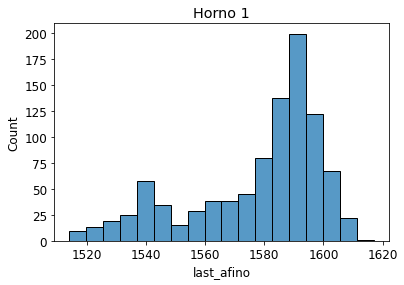

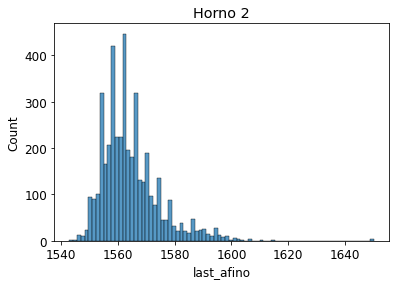

In [325]:
# Horno 1

sns.histplot(data_H1[tar])
plt.title("Horno 1")
plt.show()

sns.histplot(data_H2[tar])
plt.title("Horno 2")
plt.show()

# Análisis de importancia de variables

In [326]:
horno = 1
data = data_H1.copy()

In [327]:
data.isna().sum()

TUNDISH_HEAT_COUNTER       0
LADLE_LIFE                 0
LADLE_TOTAL_WEIGHT_RS      0
LADLE_EMPTY_TIME           0
LADLE_FULL_TIME_CURRENT    0
CASTING_TIME               0
TRANSFER_TIME_RS_CCM       0
t_liquidus                 0
nom_grado                  0
SH_promedio                0
first_afino                0
mean_temp_colada           0
last_afino                 0
dtype: int64

In [328]:
data.dropna(inplace = True)

In [329]:
corr = data.corr()

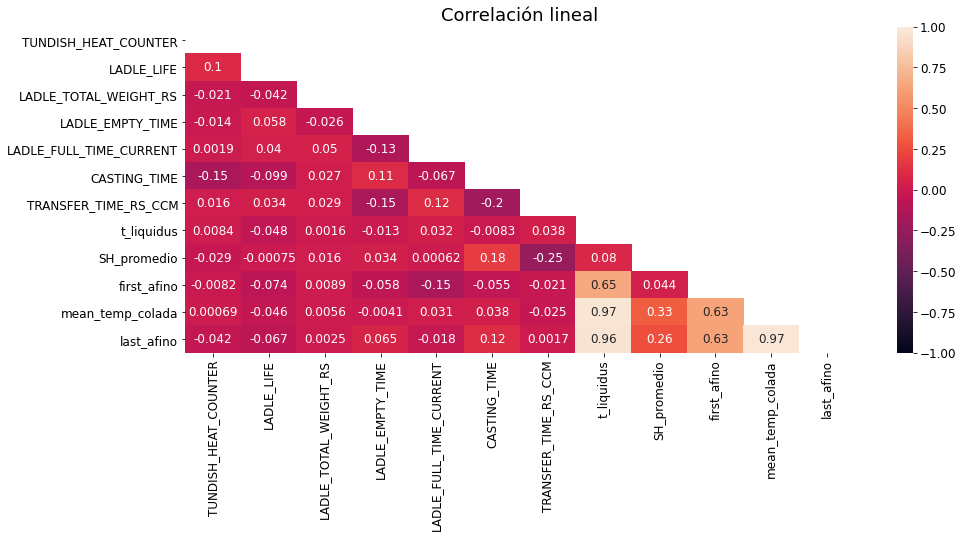

In [330]:
plt.figure(figsize=(15, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask,vmin=-1, vmax=1,annot=True)
heatmap.set_title('Correlación lineal', fontdict={'fontsize':18});

In [331]:
class feature_importance_method:
    def __init__(self, dataframe, tar="caida_temp", prc_split = 0.33, thr = None, n_features = None):    
        self.df = dataframe
        self.tar = tar
        self.prc = prc_split
        self.thr = thr
        self.n_features = n_features
    
    def TrainTest_split(self):
        # Definir variables depedientes e independientes
        self.X = self.df.drop(columns = self.tar)
        self.y = self.df[self.tar]
        
        # Train Test Split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                            test_size = self.prc, 
                                                            random_state = 42)
    
    def Permutation_method(self):
        self.TrainTest_split()
        
        # Crear instancia de Random Forest Regressor
        reg = RandomForestRegressor(random_state=0)
        # Fit a random forest regressor
        reg.fit(self.X_train, self.y_train)
        #Prediccion
        y_pred = reg.predict(self.X_test)
        self.y_pred = pd.DataFrame(y_pred, index = self.y_test.index)
        
        rmse_full_mod = mean_squared_error(self.y_pred, self.y_test, squared = False)
        # Permutacion
        results = []
        # Iterar cada columna
        for col in self.X_test.columns:
            # Creamos una copia
            X_test_copy = self.X_test.copy()

            # Sufflear cada columna
            X_test_copy[col] = self.X_test[col].sample(frac=1).values

            # Calcular el RMSE
            new_rmse = mean_squared_error(reg.predict(X_test_copy), self.y_test,
                                          squared = False)

            # Agregar a la lista de resultados
            results.append({'pred': col,
                            'score': new_rmse - rmse_full_mod })
        # Convert to a pandas dataframe and rank the predictors by score
        self.resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                                      ascending = False)
        self.reg = reg
        print("Procedmimiento exitoso")
        
    def Variance_method(self):
        self.TrainTest_split()
        
        # Crear instancia de Random Forest Regressor y Selector
        reg = RandomForestRegressor(random_state=0)
        selector = VarianceThreshold(threshold= self.thr)
        
        X_train_varthr = selector.fit_transform(self.X_train)
        X_test_varthr = selector.transform(self.X_test)
        
        reg.fit(X_train_varthr, self.y_train)
        
        #Predicción sobre test
        y_pred = reg.predict(X_test_varthr)
        self.y_pred = pd.DataFrame(y_pred, index = self.y_test.index)
        self.selected_variables = list(self.X_train.columns[selector.get_support()])
        self.reg = reg
        print("Procedmimiento exitoso")
    
    def RandomSelect_method(self):
        self.TrainTest_split()
        
        # Crear instancia de Random Forest Regressor y Selector
        reg = RandomForestRegressor(random_state=0)
        
        selector = RFE(reg, n_features_to_select = self.n_features, step=1)
        selector = selector.fit(self.X_train, self.y_train)
        
        #Predicción sobre test
        self.y_pred = selector.predict(self.X_test)
#         self.y_pred = pd.DataFrame(y_pred, index = self.y_test.index)
        self.selected_variables = list(self.X_train.columns[selector.get_support()])
        
        self.reg = selector
        print("Procedmimiento exitoso")

In [332]:
## Permutación de características

# Crear instancia de la clase para métodos de Feature importance
FIM = feature_importance_method(data[variables + [tar]], tar = "last_afino")

# Instanciar el método de Permutación de características
FIM.Permutation_method()

Procedmimiento exitoso


In [333]:
# Imprimir resultados del score
FIM.resultsdf.head(30).reset_index(drop =True)

,pred,score
0,mean_temp_colada,24.743357
1,t_liquidus,1.881070
2,CASTING_TIME,0.459108
3,TUNDISH_HEAT_COUNTER,0.221328
4,TRANSFER_TIME_RS_CCM,0.091849
5,LADLE_EMPTY_TIME,0.083106
6,LADLE_FULL_TIME_CURRENT,0.013453
7,LADLE_LIFE,-0.005218
8,LADLE_TOTAL_WEIGHT_RS,-0.022907
9,first_afino,-0.047097


Text(0.5, 1.0, 'Set de prueba: Método Permutación')

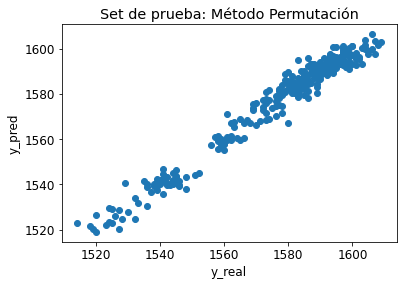

In [334]:
# Graficar los resultados de test y predict
plt.scatter(FIM.y_test, FIM.y_pred)
plt.xlabel("y_real")
plt.ylabel("y_pred")
plt.title("Set de prueba: Método Permutación")

# Train-Test split

In [335]:
# Definir variables depedientes e independientes

X = data[variables]
y = data[tar]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42)

# Pruebas Modelo

In [336]:
# Definir Pipeline para escalamiento y modelo

parameters = {'depth': [4,5,6,7,8],
                 'learning_rate' : [0.01,0.05,0.02,0.3, 0.5],
                  'iterations': [300,400,500]
                 }

RFparameters = {'max_depth': [4,5,6,7,8],
                'learning_rate' : [0.01,0.05,0.02,0.3, 0.5],
                'n_estimators': [300,400,500]
               }

GBFparameters = {
    "n_estimators": [300,400,500],
    "max_depth": [4,5,6,7,8],
    "learning_rate": [0.01,0.05,0.02,0.3, 0.5]
}


models_dict = {"LinealSimple" : LinearRegression(),
               "LRidge" : RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
               "GradientBR": RandomizedSearchCV(GradientBoostingRegressor(random_state = 0), 
                                                   param_distributions = GBFparameters, cv = 5, n_iter = 20, random_state = 0),
               
               
               "catboost": CatBoostRegressor(silent = True, random_state = 0),
               "RGridCatboost": RandomizedSearchCV(CatBoostRegressor(silent = True, random_state = 0), 
                                                   param_distributions = parameters, scoring = ["explained_variance", "r2", "neg_mean_absolute_percentage_error", "neg_mean_absolute_error"],
                                                   refit = "neg_mean_absolute_percentage_error", cv = 5, n_iter = 30, random_state = 0),
               "RGridForest": RandomForestRegressor(n_estimators=300,max_depth=7,random_state = 0)
              }

scaler_dict = {"Quantile": QuantileTransformer(n_quantiles=3, random_state=42), 
               "Sscaler": StandardScaler(),
               "MinMax": MinMaxScaler(),
               "None": None
              }

## Iteraciones de algoritmos

In [337]:
# def metricas(yreal, ypred, umbral = 5):    
#     # Cálculos
#     residuals = yreal - ypred # Error
#     std = np.std(residuals) #Desviación estándar
#     mae = mean_squared_error(yreal, ypred)
#     abserror = abs(residuals)
#     prc = 100*(abserror < umbral).sum()/len(abserror)
#     print("Testing: Error promedio = %.2f" % np.average(residuals))
#     print("Testing: Desviación estándar del error = %.2f" % std)
#     print("Testing: MSE = %.2f" % mae)
#     print("Porcentaje de coladas con un error <= %u °C: %.2f" %(umbral, prc))
    
def metricas(yreal, ypred, umbral = 5): 
    # Cálculos
    residuals = yreal - ypred # Error
    std = np.std(residuals) #Desviación estándar
    mae = mean_squared_error(yreal, ypred)
    abserror = abs(residuals)
    prc = 100*(abserror < umbral).sum()/len(abserror)
    
    df = pd.DataFrame({"Error promedio": np.average(residuals),
                        "std": std,
                        "MAE": mae,
                        f"% Error <{umbral}": prc}, index = [0]
                     )
    
    return df

In [338]:
# df_metricas = pd.DataFrame()
# for key_model in ["LRidge", "LinealSimple", "catboost", "RGridCatboost", "RGridForest", "GradientBR"]:
#     for key_scale in ["Quantile", "MinMax"]:
#         pipe = Pipeline([('scaler', scaler_dict[key_scale]),
#                         ("model", models_dict[key_model])])

#         # Entrenamiento
#         pipe.fit(X_train, y_train)

#         # Vector de predicciones
#         y_pred = pipe.predict(X_test)

    
#         df = metricas(y_test, y_pred)
#         df = (df.assign(Scale = key_scale)).assign(Modelo = key_model)
#         df_metricas = df_metricas.append(df)
#     print(f"{key_model} Listo......")

In [339]:
# df_metricas

In [340]:
horno

1

In [341]:
# # Guardar resultados de las iteraciones para seleccionar el mejor
# df_metricas.to_csv(f"../../docs/15. Sprint Resultados/Metricas_horno{horno}.csv")

In [342]:
# # Modelo elegido

# key_model = "RGridCatboost"
# key_scale =  "MinMax"
# pipe = Pipeline([('scaler', scaler_dict[key_scale]),
#                 ("model", models_dict[key_model])])

# # Entrenamiento
# pipe.fit(X_train, y_train)

# # Vector de predicciones
# y_pred = pipe.predict(X_test)

# print(f"{key_model} Listo......")

In [343]:
# ## Guardar modelo como pickle

# import pickle 

# version = "v.0"

# with open(f"../../pickles/Prediccion_HA/Temperatura_salida_HA{horno}_{version}.pickle", "wb") as file:
#     pickle.dump(pipe, file)

# Cargar modelo entrenado

In [373]:
# Abrir modelo
horno = 2
version = "v.0"
with open(f"../../pickles/Prediccion_HA/Temperatura_salida_HA{horno}_{version}.pickle", "rb") as file:
    model = pickle.load(file)

In [374]:
# Elegir dataset de horno
data = data_H2.copy()

# Definir variables depedientes e independientes
X = data[variables]
y = data[tar]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (2894, 10), X_test: (1426, 10)


In [375]:
# Predicción
y_pred = model.predict(X_test)
print(f"Prediction size: {len(y_pred)}")

Prediction size: 1426


In [376]:
# Cargar dataset de totales completo sin filtrar
data_RW = pd.read_csv("data/CT_totales.csv")
data_RW.head(1)

,cla_colada,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,...,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,tipo_colada,t_liquidus
0,123200,2021-03-30 00:00:00,3,1.0,0.0,1.0,26.0,100.78518,2021-03-29 19:36:33,2021-03-29 20:32:48,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,secuencia,1503.92396


In [377]:
# Crear tabla de importancia de variables
if horno == 1:
    # Horno1
    dfImp = pd.DataFrame({"name": X_train.columns,
    "imp":  model.named_steps["model"].coef_})
else:
    dfImp = pd.DataFrame({"name": X_train.columns,
    "imp": model.named_steps["model"].best_estimator_.feature_importances_})

dfImp = dfImp.sort_values("imp", ascending = True)
dfImp.head(2)

,name,imp
8,first_afino,1.690827
2,LADLE_TOTAL_WEIGHT_RS,2.124624


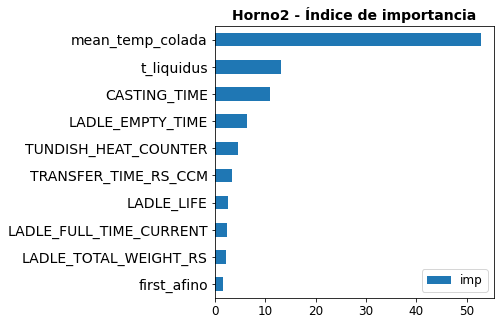

In [378]:
# Gráfica de importancia de variables

dfImp.set_index("name").plot.barh(figsize = (5,5))
plt.ylabel("")
plt.title(f"Horno{horno} - Índice de importancia", fontsize=14, fontweight = "bold")
plt.yticks(fontsize=14)
plt.show()

Testing: Error promedio = 0.15
Testing: Desviación estándar del error = 5.25
Testing: MSE = 27.55
Porcentaje de coladas con un error <= 5 °C: 79.45


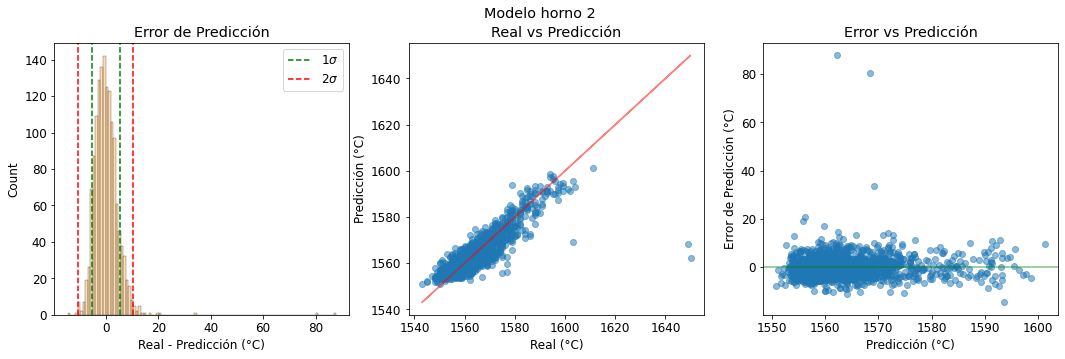

In [379]:
# Principales Gráficas de resultados 
key_model = f"Modelo horno {horno}"
results = GraficasResultados(y_test.values, y_pred, key_model, umbral=5, size=(5,5))

results.diagnostic_plots()

# Simulación - Error de modelo

In [380]:
# Abrir modelo
horno = 2
version = "v.0"
with open(f"../../pickles/Prediccion_HA/Temperatura_salida_HA{horno}_{version}.pickle", "rb") as file:
    model_simulacion = pickle.load(file)
# Elegir dataset
data = data_H2.copy()
data.head(3)

,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,nom_grado,SH_promedio,first_afino,mean_temp_colada,last_afino
cla_colada,,,,,,,,,,,,,
125224,26,50.0,151.17777,97.550000,23.866667,54.0,9.566633,1524.17945,1008 BCO,28.82055,1532,1553.0,1593
125225,27,23.0,115.60653,90.266667,18.216667,53.0,13.666667,1526.28432,1006 VDE CEL,29.71568,1597,1556.0,1595
125226,28,93.0,127.46361,72.866667,22.416667,46.0,13.499967,1526.70591,1006 VDE CEL,30.29409,1567,1557.0,1599


In [381]:
# Definir variables depedientes e independientes

X = data[variables]
y = data[tar]

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# Predicción
y_pred = model_simulacion.predict(X_test)
print(f"\nPrediction size: {len(y_pred)}")

X_train: (2894, 10), X_test: (1426, 10)

Prediction size: 1426


In [382]:
# Cargar datos de superheat real para comparar
df_temp = pd.read_csv("data/CT_caida_temp.csv")

In [383]:
df_temp.head()

,cla_colada,first_afino,fhr_muestra_first_afino,last_afino,fhr_muestra_last_afino,first_colada,fhr_muestra_first_mcc,last_colada,fhr_muestra_last_mcc,mean_temp_colada,std_temp_colada,max_colada,min_colada,SH_promedio,SH_std,SH_min,SH_max,cla_horno
0,123200,1550,2021-03-29 20:48:27,1568,2021-03-29 20:56:01,1521,2021-03-29 21:16:31,1530,2021-03-29 21:50:56,1526.714286,3.251373,1530,1521,22.790326,3.251373,17.07604,26.07604,3
1,123201,1557,2021-03-29 21:38:01,1574,2021-03-29 21:48:55,1534,2021-03-29 22:02:43,1525,2021-03-29 22:44:08,1526.800000,4.266146,1534,1523,17.968430,4.266146,14.16843,25.16843,3
2,123202,1534,2021-03-29 22:24:10,1581,2021-03-29 22:40:59,1533,2021-03-29 22:57:12,1530,2021-03-29 23:45:12,1534.333333,5.131601,1540,1530,31.382013,5.131601,27.04868,37.04868,3
3,123203,1555,2021-03-29 23:05:31,1574,2021-03-29 23:33:38,1534,2021-03-29 23:55:11,1538,2021-03-30 00:20:33,1536.000000,2.828427,1538,1534,32.557170,2.828427,30.55717,34.55717,3
4,123204,1526,2021-03-29 23:58:22,1577,2021-03-30 00:24:50,1535,2021-03-30 00:45:59,1529,2021-03-30 01:12:35,1532.000000,4.242641,1535,1529,28.231830,4.242641,25.23183,31.23183,3


In [386]:
resultados_pred = pd.DataFrame(y_test).assign(y_pred = y_pred)
resultados_pred.rename(columns = {"last_afino": "y_real"}, inplace = True)

In [387]:
resultados_pred = resultados_pred.join(df_temp.set_index("cla_colada")["SH_promedio"])

In [388]:
resultados_pred.head()

,y_real,y_pred,SH_promedio
cla_colada,,,
126221,1562,1562.384122,30.226163
125478,1568,1570.092643,30.472790
130116,1560,1557.889440,26.514430
130732,1560,1559.142632,24.725900
125557,1563,1564.063507,28.513170


In [389]:
# Calcular el residual

residuals = abs(y_test - y_pred)
residuals_ok = residuals[residuals <= 5] #Quedarnos solo con el porcentaje de datos con las métricas aceptadas

In [390]:
# Elegimos las coladas con un error de predicción dentro de +/- 5°C

resultados_pred = resultados_pred.loc[residuals_ok.index]
resultados_pred.describe()

,y_real,y_pred,SH_promedio
count,1133.000000,1133.000000,1133.000000
mean,1563.681377,1563.986434,28.813019
std,8.427302,7.948899,5.246928
min,1548.000000,1551.138981,13.150850
25%,1558.000000,1558.555973,25.395460
50%,1562.000000,1562.065670,28.676527
75%,1567.000000,1567.284748,32.017820
max,1599.000000,1598.587902,48.519113


In [391]:
resultados_pred

,y_real,y_pred,SH_promedio
cla_colada,,,
126221,1562,1562.384122,30.226163
125478,1568,1570.092643,30.472790
130116,1560,1557.889440,26.514430
130732,1560,1559.142632,24.725900
125557,1563,1564.063507,28.513170
...,...,...,...
133938,1567,1570.606527,30.139090
125995,1563,1561.977445,31.505220
130394,1561,1559.545196,29.681730


## Graficar superheat Real

In [361]:
yreal = resultados_pred["y_real"]
ypred = resultados_pred["y_pred"]
sh_real = resultados_pred["SH_promedio"]

In [395]:
#Crear dataframe para categorizar el superheat:
# 0: Superheat en control
# 1: Superheat menor que 20°C
# 2: Superheat mayor que 30°C

df_SH = pd.DataFrame(sh_real)
df_SH.head(2)

,SH_promedio
cla_colada,
126221,30.226163
125478,30.472790


In [396]:
df_SH["control"] = 0 # En control
df_SH.loc[df_SH["SH_promedio"] < 20, "control"] = 1 #Menor
df_SH.loc[df_SH["SH_promedio"] > 30, "control"] = 2 #Mayor

# Porcentaje de datos de cada categoría
prc_inf_sh = (df_SH["SH_promedio"] < 20).sum() * 100/df_SH.shape[0]
prc_sup_sh = (df_SH["SH_promedio"] > 30).sum()  * 100/df_SH.shape[0]
prc_control_sh = ((df_SH["SH_promedio"] >= 20)&(df_SH["SH_promedio"] <= 30)).sum()* 100/df_SH.shape[0]

print(f"Pocentajes:\nControl: {prc_control_sh: .2f}%, \nMenor a 20: {prc_inf_sh: .2f}%, \nMayor a 30: {prc_sup_sh: .2f}%")

Pocentajes:
Control:  56.31%, 
Menor a 20:  4.24%, 
Mayor a 30:  39.45%


In [397]:
df_SH.head()

,SH_promedio,control
cla_colada,,
126221,30.226163,2
125478,30.472790,2
130116,26.514430,0
130732,24.725900,0
125557,28.513170,0


In [398]:
## Agregar fecha administrativa
# df_SH = df_SH.join(data_RW.set_index("cla_colada")["fecha_administrativa"])

In [435]:
# Mapa de colores según categoría

dict_colors = {0: "mediumblue", 1: "gray", 2: "orangered"}
df_SH["control"] = df_SH["control"].map(dict_colors) ## Mapear cateoría a color

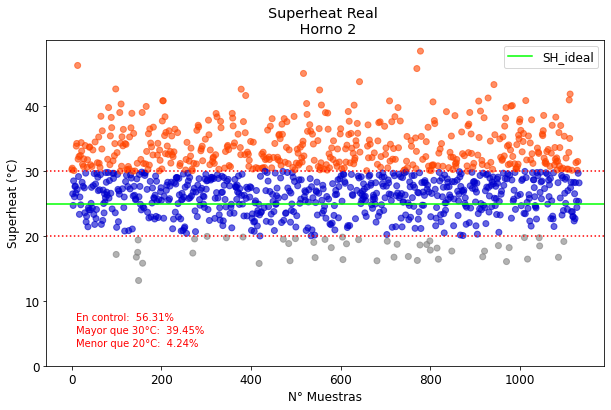

In [400]:
# Gráfica
plt.figure(figsize = (10,6))
plt.scatter(x = np.arange(len(sh_real)), y = df_SH["SH_promedio"], c = df_SH["control"], alpha = 0.6) ## Superheat
plt.axhline(y = 25, color = 'lime', label = "SH_ideal") ## Referencia de superheat ideal = 25°C
plt.axhline(y = 30, color = 'r', linestyle = "dotted") ## Referencia de superheat límite superior
plt.axhline(y = 20, color = 'r', linestyle = "dotted") ## Referencia de superheat límite inferior
# Etiquetas ejes
plt.ylabel("Superheat (°C)")
plt.xlabel("N° Muestras")
plt.title(f"""Superheat Real \n Horno {horno}""")
plt.yticks(np.arange(0, max(sh_real)+1, 10))
# Texto
params = {"fontsize": 10, "color": "red"}
plt.text(10, 7, f"En control: {prc_control_sh: .2f}%", **params)
plt.text(10, 5, f"Mayor que 30°C: {prc_sup_sh: .2f}%", **params)
plt.text(10, 3, f"Menor que 20°C: {prc_inf_sh: .2f}%", **params)
plt.legend()
plt.show()

## Gráficas superheat Error-Simulación

In [406]:
# Variable Casting time la cambiamos por el esperado

data_SIM = data.copy()
data_SIM["CASTING_TIME"] = data_SIM["CASTING_TIME"].shift()
mean_value = data_SIM["CASTING_TIME"].mean()

data_SIM["CASTING_TIME"].fillna(value=mean_value, inplace=True)

In [407]:
# Variable Casting time
data_SIM.loc[:,"mean_temp_colada"] = data_SIM.loc[:,"t_liquidus"] + 25

In [408]:
# Definir variables depedientes e independientes

X = data_SIM[variables]
y = data_SIM[tar]

# Train Test Split
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(X, y,
                                                    test_size = 0.33, 
                                                    random_state = 42)

print(f"X_train: {X_train_sim.shape}, X_test: {X_test_sim.shape}")

# Predicción
y_pred_sim = model_simulacion.predict(X_test_sim)
print(f"\nPrediction size: {len(y_pred_sim)}")

X_train: (2894, 10), X_test: (1426, 10)

Prediction size: 1426


In [426]:
# Tabla de resultados
resultados_pred_SIM = pd.DataFrame(y_test_sim).assign(y_pred = y_pred_sim)
resultados_pred_SIM.rename(columns = {"last_afino": "y_real"}, inplace = True)
resultados_pred_SIM.head(2)

,y_real,y_pred
cla_colada,,
126221,1562,1557.219019
125478,1568,1561.181757


In [427]:
# Se agrega el Superheat Real
resultados_pred_SIM = resultados_pred_SIM.join(df_temp.set_index("cla_colada")["SH_promedio"])
resultados_pred_SIM.head()

,y_real,y_pred,SH_promedio
cla_colada,,,
126221,1562,1557.219019,30.226163
125478,1568,1561.181757,30.472790
130116,1560,1555.792394,26.514430
130732,1560,1562.430894,24.725900
125557,1563,1561.602958,28.513170


In [428]:
# Elegimos las coladas con un error de predicción dentro de +/- 5°C (Las mismas elegidas en la sección anterior)
resultados_pred_SIM = resultados_pred_SIM.loc[residuals_ok.index]
resultados_pred_SIM.describe()

,y_real,y_pred,SH_promedio
count,1133.000000,1133.000000,1133.000000
mean,1563.681377,1561.180681,28.813019
std,8.427302,7.471945,5.246928
min,1548.000000,1549.584349,13.150850
25%,1558.000000,1556.429733,25.395460
50%,1562.000000,1558.940881,28.676527
75%,1567.000000,1563.623189,32.017820
max,1599.000000,1594.718626,48.519113


In [429]:
## SIMULACIÓN:
## Se asume que el error de predicción afectará directamente al superheat 

residual_sim = resultados_pred_SIM["y_real"] - resultados_pred_SIM["y_pred"]
resultados_pred_SIM["SH_Simulado"] = resultados_pred_SIM["SH_promedio"] - residual_sim #error de superheat

In [430]:
resultados_pred_SIM.head(2)

,y_real,y_pred,SH_promedio,SH_Simulado
cla_colada,,,,
126221,1562,1557.219019,30.226163,25.445183
125478,1568,1561.181757,30.472790,23.654547


In [436]:
df_SHSIM = pd.DataFrame(resultados_pred_SIM["SH_Simulado"])

df_SHSIM["control"] = 0 # En control
df_SHSIM.loc[df_SHSIM["SH_Simulado"] < 20, "control"] = 1 #Menor
df_SHSIM.loc[df_SHSIM["SH_Simulado"] > 30, "control"] = 2 #Mayor

# Porcentaje de datos de cada categoría
prc_inf_sh = (df_SHSIM["SH_Simulado"] < 20).sum() * 100/df_SHSIM.shape[0]
prc_sup_sh = (df_SHSIM["SH_Simulado"] > 30).sum()  * 100/df_SHSIM.shape[0]
prc_control_sh = ((df_SHSIM["SH_Simulado"] >= 20)&(df_SHSIM["SH_Simulado"] <= 30)).sum()* 100/df_SHSIM.shape[0]

print(f"Pocentajes:\nControl: {prc_control_sh: .2f}%, \nMenor a 20: {prc_inf_sh: .2f}%, \nMayor a 30: {prc_sup_sh: .2f}%")

Pocentajes:
Control:  80.05%, 
Menor a 20:  4.15%, 
Mayor a 30:  15.80%


In [438]:
# Mapear categoría a color 
df_SHSIM["control"] = df_SHSIM["control"].map(dict_colors) ## 

In [444]:
df_SHSIM.head(2)

,SH_Simulado,control
cla_colada,,
126221,25.445183,mediumblue
125478,23.654547,mediumblue


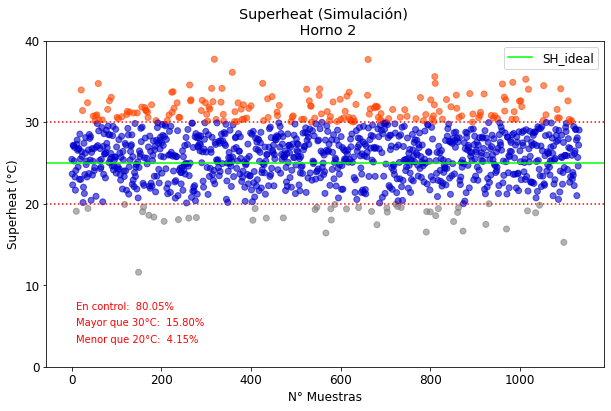

In [442]:
# Gráfica
plt.figure(figsize = (10,6))
plt.scatter(x = np.arange(len(sh_real)), y = df_SHSIM["SH_Simulado"], c = df_SHSIM["control"], alpha = 0.6) ## Superheat
plt.axhline(y = 25, color = 'lime', label = "SH_ideal") ## Referencia de superheat ideal = 25°C
plt.axhline(y = 30, color = 'r', linestyle = "dotted") ## Referencia de superheat límite superior
plt.axhline(y = 20, color = 'r', linestyle = "dotted") ## Referencia de superheat límite inferior
# Etiquetas ejes
plt.ylabel("Superheat (°C)")
plt.xlabel("N° Muestras")
plt.title(f"""Superheat (Simulación) \n Horno {horno}""")
plt.yticks(np.arange(0, max(sh_real)+1, 10))
# Texto
params = {"fontsize": 10, "color": "red"}
plt.text(10, 7, f"En control: {prc_control_sh: .2f}%", **params)
plt.text(10, 5, f"Mayor que 30°C: {prc_sup_sh: .2f}%", **params)
plt.text(10, 3, f"Menor que 20°C: {prc_inf_sh: .2f}%", **params)
plt.legend()
plt.show()

# Simulación - Online

In [135]:
# sns.histplot(data["CASTING_TIME"])

In [58]:
# # Variable Casting time la cambiamos por el esperado

# data["CASTING_TIME"] = data["CASTING_TIME"].shift()
# mean_value = data["CASTING_TIME"].mean()

# data["CASTING_TIME"].fillna(value=mean_value, inplace=True)

In [59]:
# # Variable Casting time
# data.loc[:,"mean_temp_colada"] = data.loc[:,"t_liquidus"] + 25

In [136]:
# data.head(2)

In [137]:
# # Definir variables depedientes e independientes

# X = data[variables]
# y = data[tar]

# # Train Test Split
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size = 0.33, 
#                                                     random_state = 42)
# print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

In [138]:
# y_pred_sim = model_simulacion.predict(X_test)

In [139]:
# # Instancia de modelo
# key_model = "Modelo horno 2"
# results = GraficasResultados(y_test.values, y_pred_sim, key_model, umbral=5)

# results.diagnostic_plots()

In [253]:
from datetime import datetime as dt

def Calcular_Features(distri_col_contador, 
                      col_olla, 
                      mean_tons_pq_buena,
                      flujo_mcc,
                      fecha_inicio_vaciado,
                      fhr_cierre_vd_ant, 
                      fhr_abre_vd_ant,
                      fecha_hr_ini_trat, 
                      fecha_hr_ini_trat_ant,
                      tpo_min_total_ant,
                      t_liquidus,
                      first_afino):
    """
    Inputs:
        distri_col_contador: (int) Número de coladas procesadas por el distribuidor
        col_olla: (int) Número de coladas que pasaron por la olla antes de ser cambiada
        mean_tons_pq_buena: (float) Promedio de las últimas 3 coladas de la variable "tons_pq_buena"
        fecha_inicio_vaciado: (str) Variable "fecha_inicio_vaciado"
        fhr_cierre_vd_ant: (str) Variable "fhr_cierre_vd" de la colada anterior de la olla actual
        fhr_abre_vd_ant: (str) Variable "fhr_abre_vd" de la colada anterior
        fecha_hr_ini_trat: (str) Variable "fecha_hr_ini_trat"
        fecha_hr_ini_trat_ant: (str) Variable "fecha_hr_ini_trat" de la colada anterior
        tpo_min_total_ant: (float) Variable "tpo_min_total" de la colda anterior
        t_liquidus: (float) Temperatura de liquidus
        first_afino: (float) Primera temperatura del horno de Afino

    Returns:
        Dataframe : Dataframe de variables independientes para estimar temperatura
    """
    try:
        #--- Convertir a formato de fecha-hora---#
        fecha_inicio_vaciado_obj = dt.strptime(fecha_inicio_vaciado, '%Y-%m-%d %H:%M:%S') #OLLA *
        fhr_cierre_vd_ant_obj = dt.strptime(fhr_cierre_vd_ant, '%Y-%m-%d %H:%M:%S') #OLLA *
        fhr_abre_vd_ant_obj = dt.strptime(fhr_abre_vd_ant, '%Y-%m-%d %H:%M:%S')
        fecha_hr_ini_trat_obj = dt.strptime(fecha_hr_ini_trat, '%Y-%m-%d %H:%M:%S') # *
        fecha_hr_ini_trat_ant_obj = dt.strptime(fecha_hr_ini_trat_ant, '%Y-%m-%d %H:%M:%S') 
    
        #--- Calcular variables---# 
        LADLE_EMPTY_TIME = (fecha_inicio_vaciado_obj - fhr_cierre_vd_ant_obj).seconds/60 
        CASTING_TIME = mean_tons_pq_buena*1000/flujo_mcc
        LADLE_FULL_TIME_CURRENT = (fecha_hr_ini_trat_obj - fecha_inicio_vaciado_obj).seconds/60 #Colada actual
        TRANSFER_TIME_RS_CCM =  (fhr_abre_vd_ant_obj - fecha_hr_ini_trat_ant_obj).seconds/60 - tpo_min_total_ant
        
        #--- Crear dataframe de variables independientes---#

        variables_modelo = {"TUNDISH_HEAT_COUNTER": distri_col_contador,
                            "LADLE_LIFE": col_olla,
                            "LADLE_TOTAL_WEIGHT_RS": mean_tons_pq_buena,
                            "LADLE_EMPTY_TIME": LADLE_EMPTY_TIME,
                            "LADLE_FULL_TIME_CURRENT": LADLE_FULL_TIME_CURRENT,
                            "CASTING_TIME": CASTING_TIME,
                            "TRANSFER_TIME_RS_CCM": TRANSFER_TIME_RS_CCM,
                            "t_liquidus": t_liquidus,
                            "first_afino": first_afino,
                            "mean_temp_colada": t_liquidus + 25
                            }

        X_test = pd.DataFrame(variables_modelo, index = [0])

        return X_test
    except Exception as e:
        print(Exception)
        return

In [228]:
X_test.sort_index()

,TUNDISH_HEAT_COUNTER,LADLE_LIFE,LADLE_TOTAL_WEIGHT_RS,LADLE_EMPTY_TIME,LADLE_FULL_TIME_CURRENT,CASTING_TIME,TRANSFER_TIME_RS_CCM,t_liquidus,first_afino,mean_temp_colada
cla_colada,,,,,,,,,,
125224,26,50.0,151.17777,97.550000,23.866667,54.0,9.566633,1524.17945,1532,1553.000000
125242,44,97.0,148.21350,95.216667,10.683333,42.0,8.166700,1516.26498,1564,1541.000000
125243,45,74.0,135.62226,87.000000,13.416667,45.0,7.333333,1508.19127,1583,1539.333333
125244,46,55.0,112.03578,94.000000,10.266667,45.0,8.216633,1496.95203,1557,1526.666667
125248,50,56.0,138.57057,94.783333,10.050000,48.0,7.133367,1498.86244,1551,1530.000000
...,...,...,...,...,...,...,...,...,...,...
135523,14,23.0,135.46715,75.516667,23.966667,55.0,13.599967,1527.09772,1594,1555.000000
135524,15,42.0,131.29893,72.683333,20.016667,48.0,19.483300,1528.64155,1625,1559.500000
135530,5,94.0,127.07145,93.116667,13.700000,54.0,16.316633,1496.21234,1537,1532.444444


In [277]:
colada = 125244
X_test.loc[colada]

TUNDISH_HEAT_COUNTER         46.000000
LADLE_LIFE                   55.000000
LADLE_TOTAL_WEIGHT_RS       112.035780
LADLE_EMPTY_TIME             94.000000
LADLE_FULL_TIME_CURRENT      10.266667
CASTING_TIME                 45.000000
TRANSFER_TIME_RS_CCM          8.216633
t_liquidus                 1496.952030
first_afino                1557.000000
mean_temp_colada           1526.666667
Name: 125244, dtype: float64

In [278]:
colada = 125243
X_test.loc[colada]

TUNDISH_HEAT_COUNTER         45.000000
LADLE_LIFE                   74.000000
LADLE_TOTAL_WEIGHT_RS       135.622260
LADLE_EMPTY_TIME             87.000000
LADLE_FULL_TIME_CURRENT      13.416667
CASTING_TIME                 45.000000
TRANSFER_TIME_RS_CCM          7.333333
t_liquidus                 1508.191270
first_afino                1583.000000
mean_temp_colada           1539.333333
Name: 125243, dtype: float64

In [159]:
data_RW.head(1)

,cla_colada,fecha_administrativa,cla_horno,num_tratamiento,hay_distri,hay_empalme,cla_distribuidor,tons_pq_buena,fhr_ini,fhr_fin,...,lquim_f5,fecha_inicio_vaciado,fecha_fin_vaciado,min_duracion_vaciado,tiempo_contacto,Temp_SHeat,Temp_SHeat_Min,Temp_SHeat_Max,tipo_colada,t_liquidus
0,123200,2021-03-30 00:00:00,3,1.0,0.0,1.0,26.0,100.78518,2021-03-29 19:36:33,2021-03-29 20:32:48,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,secuencia,1503.92396


In [279]:
## Olla anterior colada 125240

In [280]:
RAW[RAW["cla_colada"] == 125244]["first_afino"]

1954    1557
Name: first_afino, dtype: int64

In [281]:
data_RW[data_RW["cla_colada"].isin([125243, 125242, 125241, 125244])]["tons_pq_buena"]

1815    136.35642
1816    148.21350
1817    135.62226
1818    112.03578
Name: tons_pq_buena, dtype: float64

In [282]:
# distri_col_contador = 22
# col_olla = 52
# mean_tons_pq_buena = 115.606530
# flujo = 3000
# fecha_inicio_vaciado = "2022-01-15 12:31:10"
# fhr_cierre_vd_ant = "2022-01-15 11:09:00"
# fhr_abre_vd_ant = "2022-01-15 10:25:00"
# fecha_hr_ini_trat = "2022-01-15 12:44:02"
# fecha_hr_ini_trat_ant = "2022-01-15 09:48:28"
# tpo_min_total_ant = 29.1
# t_liquidus = 1474.605780
# first_afino = 1521


## Definir parametros para prueba en online
## colada : 125244
distri_col_contador = 46
col_olla = 55
mean_tons_pq_buena = 140
flujo = 3000 ## kg/min para 6 lineas
fecha_inicio_vaciado = "2021-06-16 14:30:00"
fhr_cierre_vd_ant = "2021-06-16 12:56:00"
fhr_abre_vd_ant = "2021-06-16 14:28:00"
fecha_hr_ini_trat = "2021-06-16 14:40:16"
fecha_hr_ini_trat_ant = "2021-06-16 13:51:25"
tpo_min_total_ant = 29.25
t_liquidus = 1496.95203
first_afino = 1557

In [283]:
X_prueba = Calcular_Features(distri_col_contador, 
                      col_olla, 
                      mean_tons_pq_buena,
                      flujo,       
                      fecha_inicio_vaciado,
                      fhr_cierre_vd_ant, 
                      fhr_abre_vd_ant,
                      fecha_hr_ini_trat, 
                      fecha_hr_ini_trat_ant,
                      tpo_min_total_ant,
                      t_liquidus,
                      first_afino)

In [284]:
## SIMULACION
X_prueba.T

,0
TUNDISH_HEAT_COUNTER,46.000000
LADLE_LIFE,55.000000
LADLE_TOTAL_WEIGHT_RS,140.000000
LADLE_EMPTY_TIME,94.000000
LADLE_FULL_TIME_CURRENT,10.266667
CASTING_TIME,46.666667
TRANSFER_TIME_RS_CCM,7.333333
t_liquidus,1496.952030
first_afino,1557.000000
mean_temp_colada,1521.952030


In [285]:
## REAL
X_test.loc[125244]

TUNDISH_HEAT_COUNTER         46.000000
LADLE_LIFE                   55.000000
LADLE_TOTAL_WEIGHT_RS       112.035780
LADLE_EMPTY_TIME             94.000000
LADLE_FULL_TIME_CURRENT      10.266667
CASTING_TIME                 45.000000
TRANSFER_TIME_RS_CCM          8.216633
t_liquidus                 1496.952030
first_afino                1557.000000
mean_temp_colada           1526.666667
Name: 125244, dtype: float64

In [267]:
X_test.loc[125244]

TUNDISH_HEAT_COUNTER         46.000000
LADLE_LIFE                   55.000000
LADLE_TOTAL_WEIGHT_RS       112.035780
LADLE_EMPTY_TIME             94.000000
LADLE_FULL_TIME_CURRENT      10.266667
CASTING_TIME                 45.000000
TRANSFER_TIME_RS_CCM          8.216633
t_liquidus                 1496.952030
first_afino                1557.000000
mean_temp_colada           1526.666667
Name: 125244, dtype: float64

In [268]:
model.predict(X_prueba)

array([1561.14126812])

In [269]:
model.predict(pd.DataFrame(X_test.loc[125244]).T)

array([1565.05932634])

In [270]:
y_test[125244]

1563

In [290]:
# Superheat real para comparar
df_temp[df_temp["cla_colada"] == 125244]["SH_promedio"]

1818    29.714637
Name: SH_promedio, dtype: float64